In [ ]:
%tensorflow_version 2.x
from tensorflow import keras
from keras.layers import Dense,Conv2D,Flatten,MaxPool2D,Dropout,BatchNormalization, Input
from tensorflow.keras.optimizers import Adam
from keras.callbacks import ReduceLROnPlateau
from keras import callbacks
from keras.models import Model

from keras.preprocessing.image import load_img
from keras.preprocessing.image import img_to_array

import pandas as pd
import numpy as np
import os
import gdown

from zipfile import ZipFile
import matplotlib.pyplot as plt

# We install the FER() library to perform facial recognition
# This installation will also take care of any of the above dependencies if they are missing
!pip install FER
#from fer import FER

     |████████████████████████████████| 812 kB 32.0 MB/s 
     |████████████████████████████████| 2.3 MB 60.1 MB/s 


In [ ]:
%tensorflow_version 2.x
from tensorflow import keras
from keras.layers import Dense,Conv2D,Flatten,MaxPool2D,Dropout,BatchNormalization, Input
from tensorflow.keras.optimizers import Adam
from keras.callbacks import ReduceLROnPlateau
from keras import callbacks
from keras.models import Model

from keras.preprocessing.image import load_img
from keras.preprocessing.image import img_to_array

import pandas as pd
import numpy as np
import os
import gdown

from zipfile import ZipFile
import matplotlib.pyplot as plt

# We install the FER() library to perform facial recognition
# This installation will also take care of any of the above dependencies if they are missing
#!pip install FER

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
X_total_np = np.load('/content/drive/MyDrive/TFG/X_corrected_15052022.npz', allow_pickle=True)['arr_0']
Y_total_np = np.load('/content/drive/MyDrive/TFG/Y_corrected_15052022.npz', allow_pickle=True)['arr_0']

In [ ]:
df= pd.DataFrame(Y_total_np, columns='predicted_age	gender	expression	hair_color'.split())
df

,predicted_age,gender,expression,hair_color
0,36,1,happy,Brown_Hair
1,32,1,happy,Brown_Hair
2,31,1,neutral,Brown_Hair
3,30,0,happy,Black_Hair
4,31,0,neutral,Black_Hair
...,...,...,...,...
9959,31,0,angry,Gray_Hair
9960,39,0,angry,Blond_Hair
9961,36,1,angry,Blond_Hair
9962,27,0,angry,Brown_Hair


In [ ]:
import numpy as np 
import pandas as pd
import os
import glob
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
#dataset_folder_name = dir_data
TRAIN_TEST_SPLIT = 0.7
dataset_dict = {
    # 'angry', 'fear', 'happy', 'neutral', 'sad', 'surprise'
    'expression_id': {
        0: 'happy',  
        1: 'neutral', 
        2: 'sad', 
        3: 'angry',
        4: 'fear_surprise',
    },
    'gender_id': {
        0: '0',
        1: '1'
    },
    'hair_id': {
        0: 'Black_Hair',
        1: 'Brown_Hair',
        2: 'Blond_Hair',
        3: 'Gray_Hair',
    }
}
dataset_dict['gender_alias'] = dict((g, i) for i, g in dataset_dict['gender_id'].items())
dataset_dict['expression_alias'] = dict((r, i) for i, r in dataset_dict['expression_id'].items())
dataset_dict['hair_alias'] = dict((r, i) for i, r in dataset_dict['hair_id'].items())

In [ ]:
HEIGHT, WIDTH, _ = X_total_np[0].shape

In [ ]:
Y_total_np[110]

array([30, 1, 'neutral', 'Brown_Hair'], dtype=object)

In [ ]:
from tensorflow.keras.utils import to_categorical
from PIL import Image
TRAIN_TEST_SPLIT = 0.7
class FaceDataGenerator():
    """
    Data generator for the CELEBA dataset. This class should be used when training our Keras multi-output model.
    """
    def __init__(self, images_array, df):
        self.images_array = images_array
        self.df = df
        
    def generate_split_indexes(self):
        p = np.random.permutation(len(self.df))
        train_up_to = int(len(self.df) * TRAIN_TEST_SPLIT)
        train_idx = p[:train_up_to]
        test_idx = p[train_up_to:]
        train_up_to = int(train_up_to * TRAIN_TEST_SPLIT)
        train_idx, valid_idx = train_idx[:train_up_to], train_idx[train_up_to:]
        
        # converts alias to id
        self.df['gender_id'] = self.df['gender'].map(lambda gender: dataset_dict['gender_alias'][gender])
        self.df['expression_id'] = self.df['expression'].map(lambda race: dataset_dict['expression_alias'][race])
        self.df['hair_id'] = self.df['hair_color'].map(lambda hair: dataset_dict['hair_alias'][hair])
        self.max_age = self.df['predicted_age'].max()

        #print(train_idx)
        
        return train_idx, valid_idx, test_idx
    
    def preprocess_image(self, img_path):
        """
        Used to perform some minor preprocessing on the image before inputting into the network.
        """
        im = Image.open(img_path)
        im = im.resize((WIDTH, HEIGHT))
        im = np.array(im) / 255.0
        
        return im
        
    def generate_images(self, image_idx, is_training, batch_size=16):
        """
        Used to generate a batch with images when training/testing/validating our Keras model.
        """
        
        # arrays to store our batched data
        images, ages, facial_expressions, genders, hairs = [], [], [], [], []
        while True:
            for idx in image_idx:
                person = self.df.iloc[idx]
                
                age = person['predicted_age']
                expression = person['expression_id']
                gender = person['gender_id']
                hair = person['hair_id']
                #file = person['image_id']
                
                #im = self.preprocess_image(image_dir+file)
                
                #ages.append(age / self.max_age)
                ages.append(age)
                facial_expressions.append(to_categorical(expression, len(dataset_dict['expression_id'])))
                genders.append(to_categorical(gender, len(dataset_dict['gender_id'])))
                hairs.append(to_categorical(hair, len(dataset_dict['hair_id'])))
                images.append(self.images_array[idx])
                #print(facial_expressions)
                # yielding condition
                if len(images) >= batch_size:
                    
                    yield np.array(images), [np.array(ages), np.array(facial_expressions), np.array(genders), np.array(hairs)]
                    images, ages, facial_expressions, genders, hairs = [], [], [], [], []
                    
            if not is_training:
                break


data_generator = FaceDataGenerator(X_total_np, df)
train_idx, valid_idx, test_idx = data_generator.generate_split_indexes() 

# Testing on testing data

In [ ]:
from sklearn.metrics import classification_report


def class_report(true, pred, alias):
  cr = classification_report(true, pred, target_names=dataset_dict[alias].keys())
  print(cr)


def test_model(model_path):
  # Recrea exactamente el mismo modelo solo desde el archivo
  model_loaded = keras.models.load_model(model_path)
  test_batch_size = 128
  test_generator = data_generator.generate_images(test_idx, is_training=False, batch_size=test_batch_size)
  age_pred, expressions_pred, gender_pred, hair_pred  = model_loaded.predict(test_generator)
  test_generator = data_generator.generate_images(test_idx, is_training=False, batch_size=test_batch_size)
  samples = 0
  images, age_true, expression_true, gender_true, hair_true = [], [], [], [], []
  for test_batch in test_generator:
      image = test_batch[0]
      labels = test_batch[1]
      
      images.extend(image)
      age_true.extend(labels[0])
      expression_true.extend(labels[1])
      gender_true.extend(labels[2])
      hair_true.extend(labels[3])
      
  age_true = np.array(age_true)
  expression_true = np.array(expression_true)
  gender_true = np.array(gender_true)
  hair_true = np.array(hair_true)
  expression_true, gender_true, hair_true = expression_true.argmax(axis=-1), gender_true.argmax(axis=-1), hair_true.argmax(axis=-1)
  expressions_pred, gender_pred, hair_pred = expressions_pred.argmax(axis=-1), gender_pred.argmax(axis=-1), hair_pred.argmax(axis=-1)
  age_true = age_true * data_generator.max_age
  age_pred = age_pred * data_generator.max_age
  # expression_alias
  class_report(expression_true, expressions_pred, 'expression_alias')
  class_report(gender_true, gender_pred, 'gender_alias')
  class_report(hair_true, hair_pred, 'hair_alias')
  from sklearn.metrics import r2_score
  print('R2 score for age: ', r2_score(age_true, age_pred))

In [ ]:
old_models = ['/content/drive/MyDrive/TFG/trained models/face_descriptor_model_v2_latest_expression_70_accuracy.h5', '/content/drive/MyDrive/TFG/trained models/face_descriptor_model_corrected_data_15_05_2022_width_height_correct.h5' ]

In [ ]:
import os                                                                   
import glob                                                                 
os.chdir('/content/drive/MyDrive/TFG/trained models')         
for file in ['/content/drive/MyDrive/TFG/trained models/face_descriptor_model_corrected_data_15_05_2022_width_height_correct.h5', '/content/drive/MyDrive/TFG/trained models/face_descriptor_model_corrected_data_15_05_2022 (1).h5', '/content/drive/MyDrive/TFG/trained models/face_descriptor_model_corrected_data_15_05_2022.h5', '/content/drive/MyDrive/TFG/trained models/face_descriptor_model_corrected_data_15_05_2022_grande_ultimo_15_05_2022.h5' ]:#list(glob.glob('*.h5')):
  print('-'*40)
  print(file)
  test_model(file)

----------------------------------------
/content/drive/MyDrive/TFG/trained models/face_descriptor_model_corrected_data_15_05_2022_width_height_correct.h5
               precision    recall  f1-score   support

        happy       0.72      0.88      0.79       635
      neutral       0.60      0.58      0.59       617
          sad       0.53      0.70      0.60       531
        angry       0.77      0.53      0.63       541
fear_surprise       0.84      0.67      0.75       620

     accuracy                           0.68      2944
    macro avg       0.69      0.67      0.67      2944
 weighted avg       0.69      0.68      0.68      2944

              precision    recall  f1-score   support

           0       0.99      0.86      0.92      1515
           1       0.87      0.99      0.93      1429

    accuracy                           0.92      2944
   macro avg       0.93      0.92      0.92      2944
weighted avg       0.93      0.92      0.92      2944

              precis

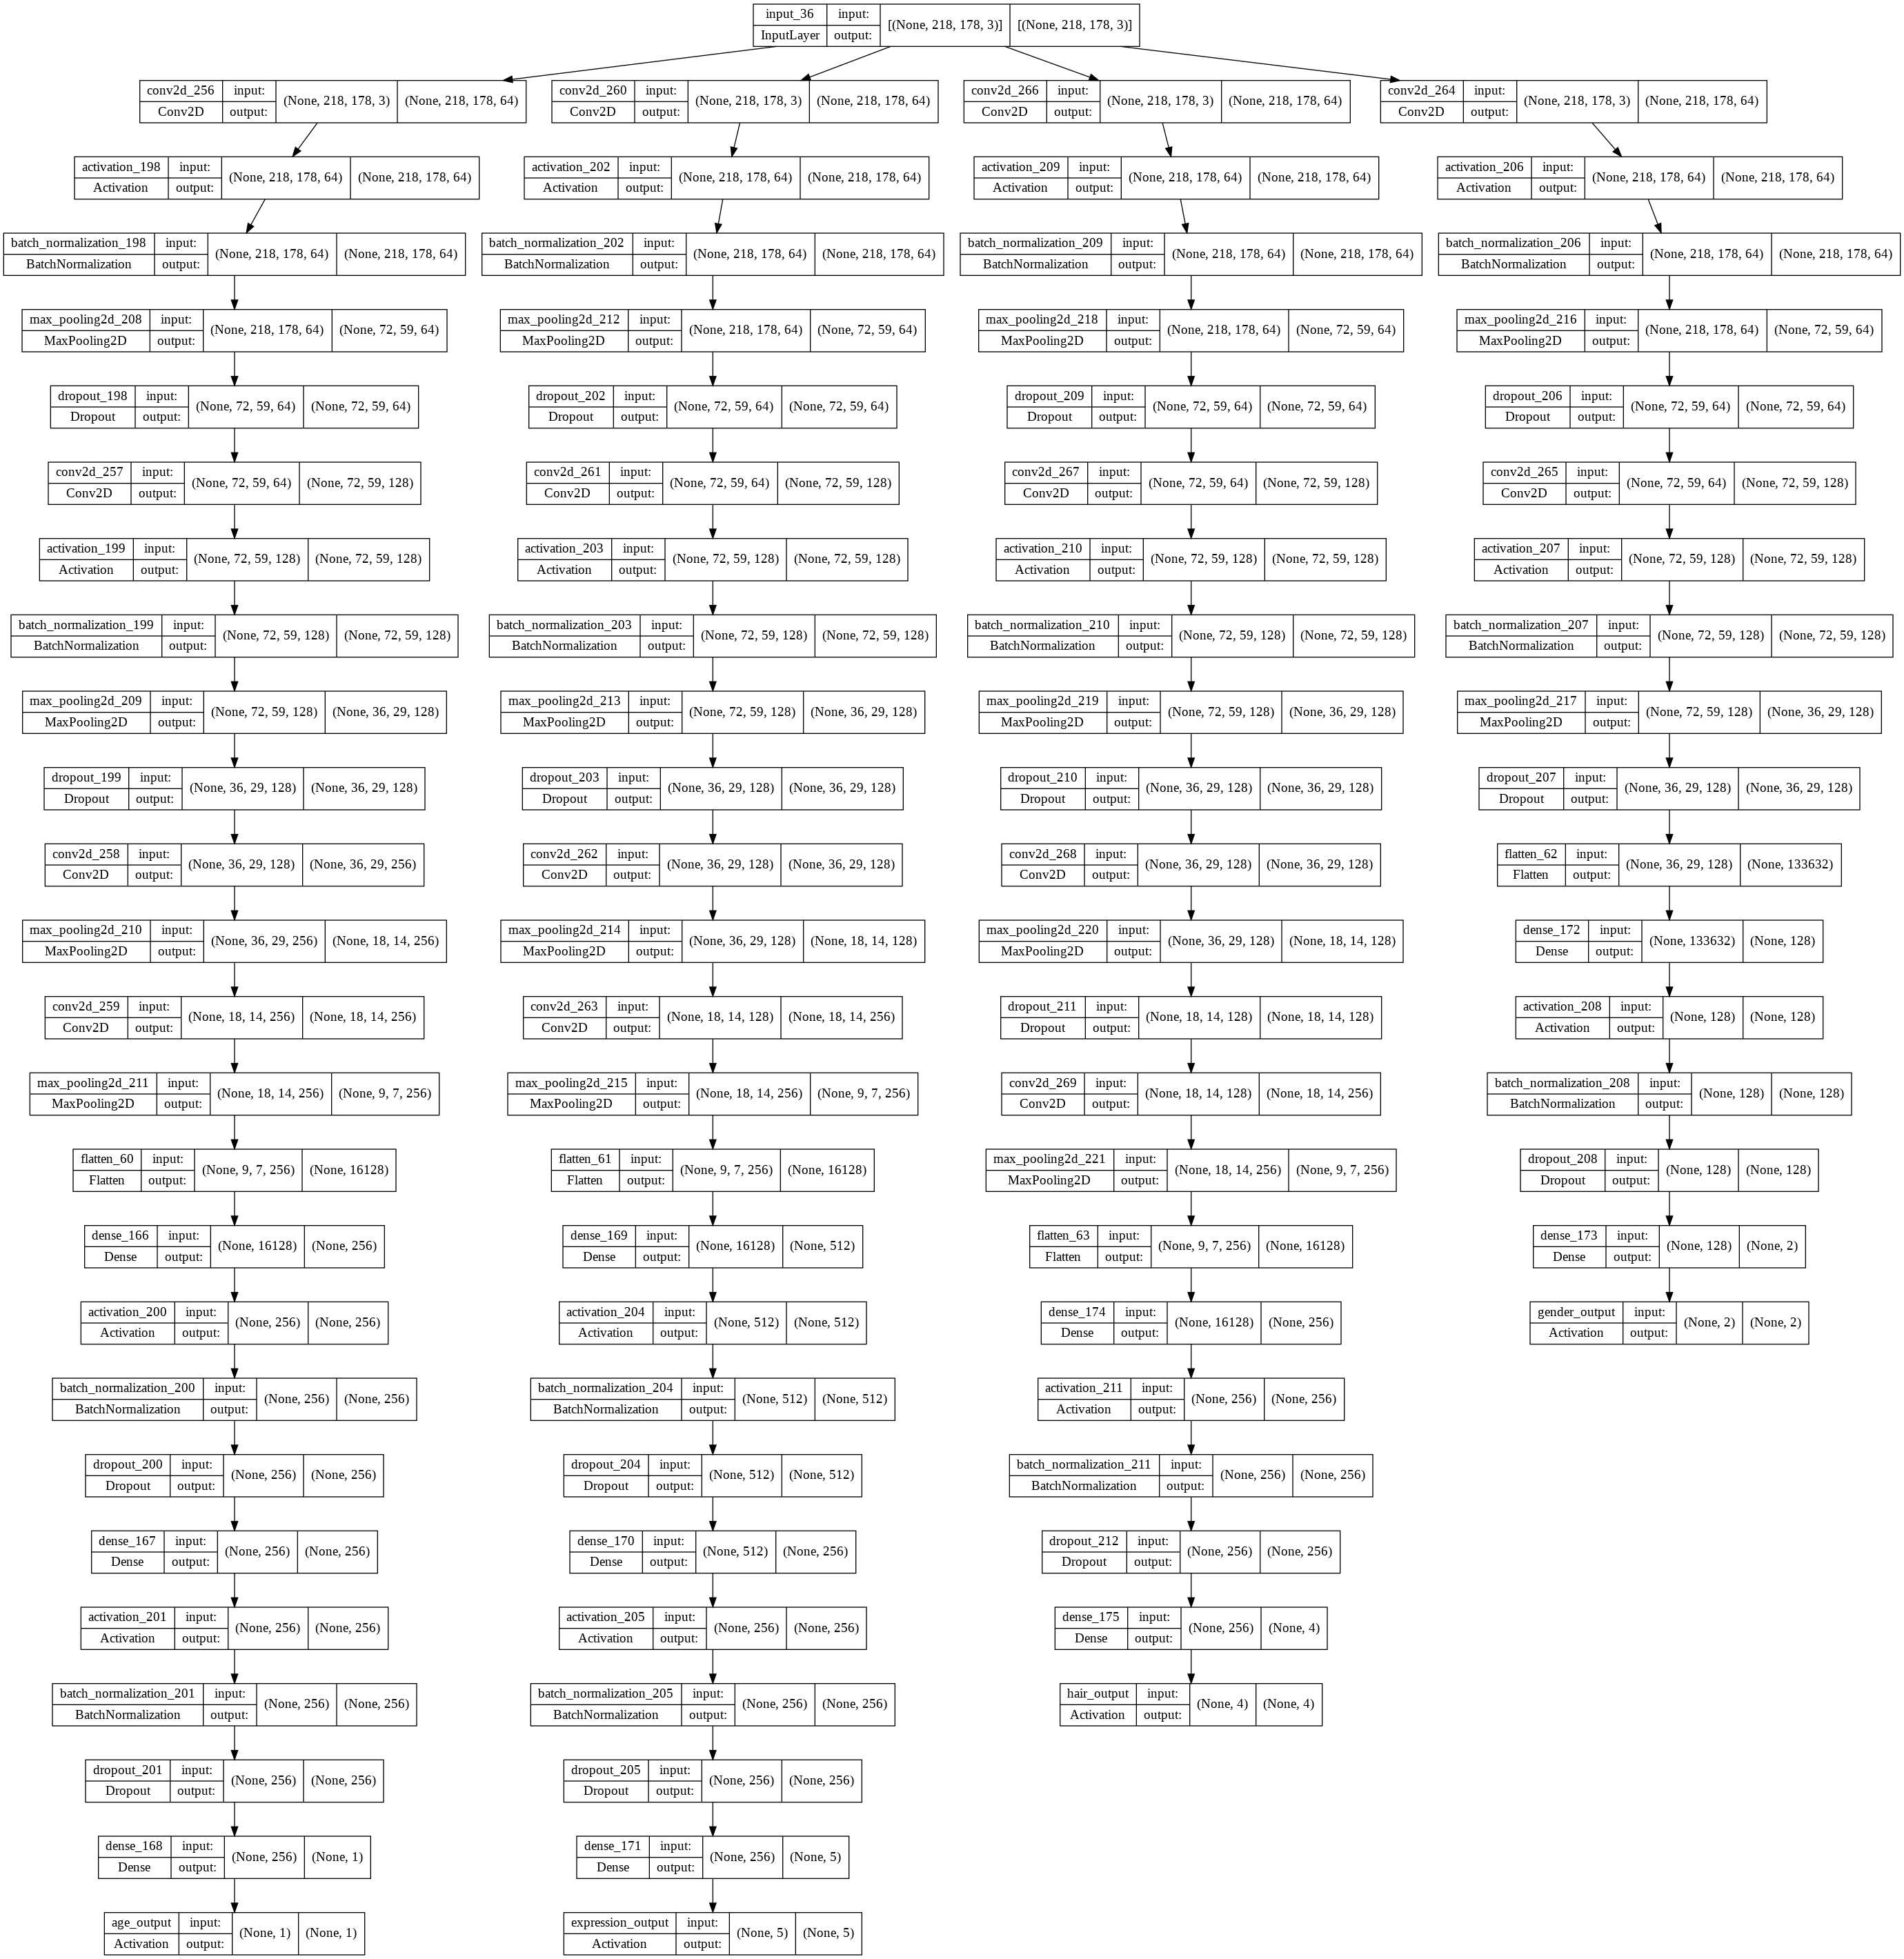

In [ ]:
from keras.utils.vis_utils import plot_model
model = keras.models.load_model('/content/drive/MyDrive/TFG/trained models/face_descriptor_model_corrected_data_15_05_2022_grande_ultimo_15_05_2022.h5')
plot_model(model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)

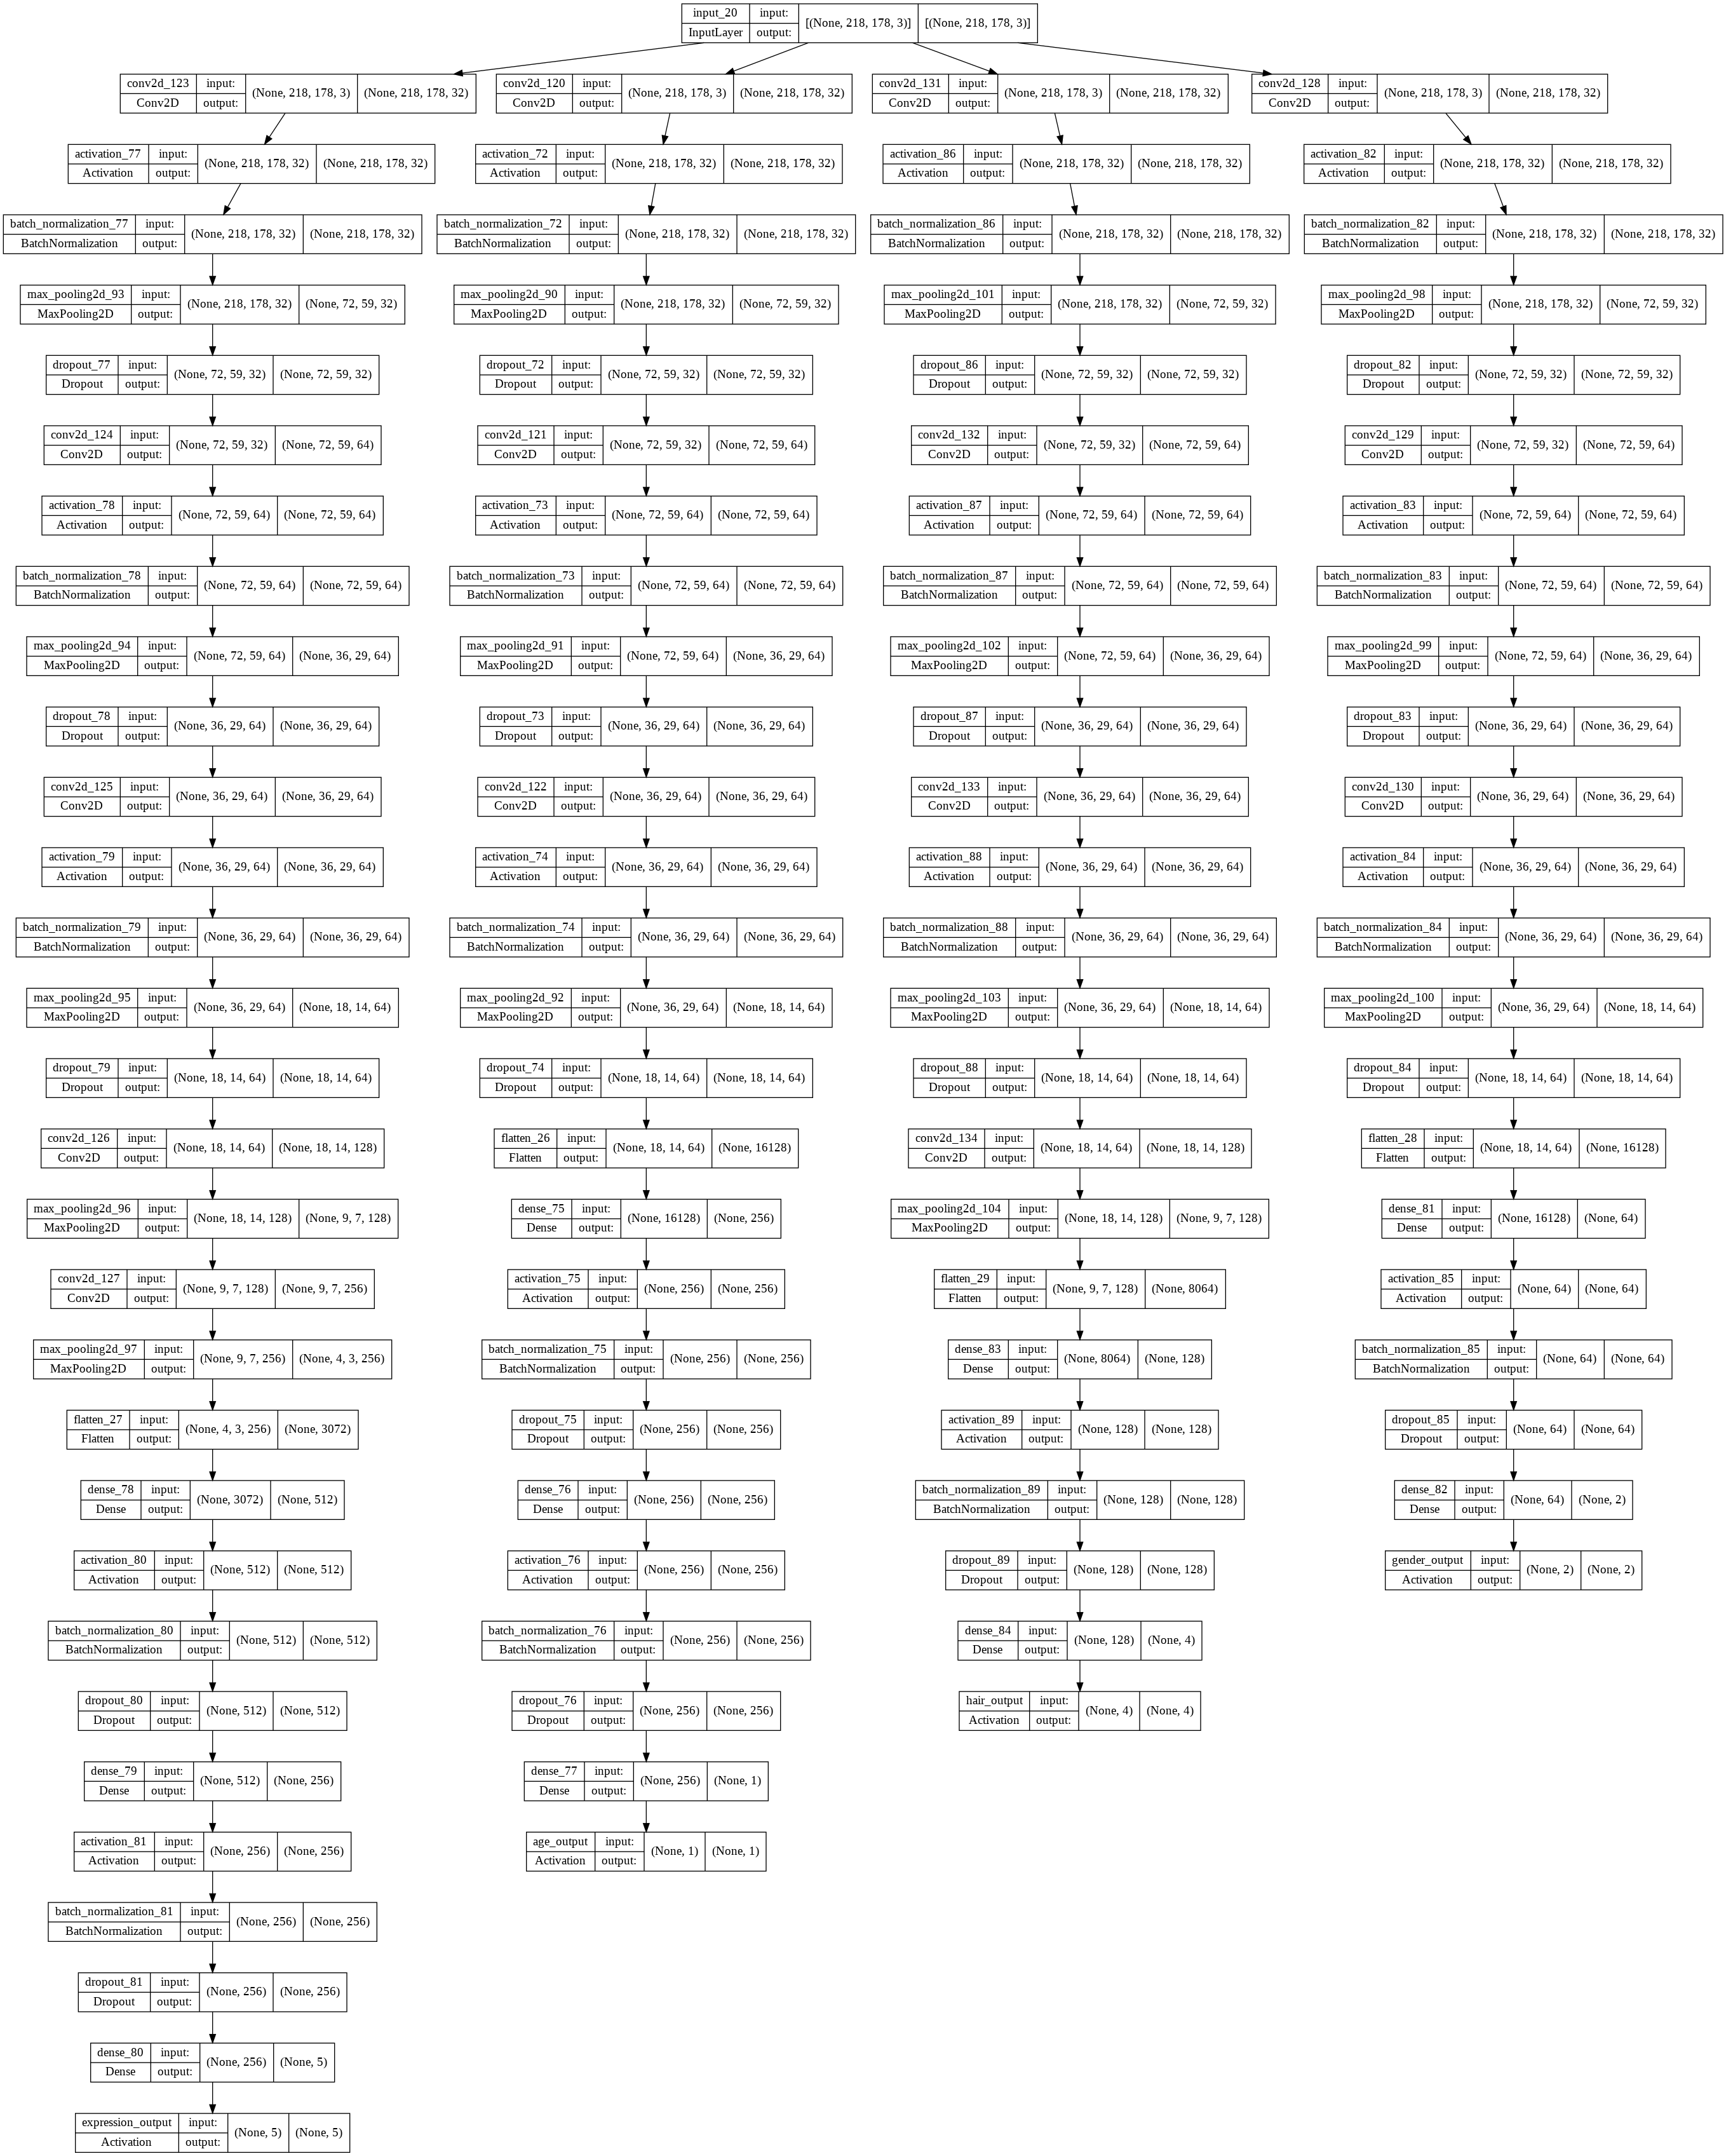

In [ ]:
from keras.utils.vis_utils import plot_model
model = keras.models.load_model('/content/drive/MyDrive/TFG/trained models/face_descriptor_model_corrected_data_15_05_2022_width_height_correct.h5')
plot_model(model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)

# Testing with camera

In [ ]:
!pip install MTCNN
from os import listdir
from os.path import isdir
from PIL import Image
from matplotlib import pyplot
from numpy import savez_compressed
from numpy import asarray
from mtcnn.mtcnn import MTCNN
import tensorflow as tf
from tensorflow.keras.preprocessing import image
# Helper libraries
import numpy as np
import matplotlib.pyplot as pl


# extract a single face from a given photograph
def extract_face(filename, required_size=(WIDTH, HEIGHT)):
  # load image from file
  image = Image.open(filename)
  # convert to RGB, if needed
  image = image.convert('RGB')
  # convert to array
  pixels = asarray(image)
  # create the detector, using default weights
  detector = MTCNN()
  # detect faces in the image
  results = detector.detect_faces(pixels)
  # extract the bounding box from the first face
  try:
    x1, y1, width, height = results[0]['box']
    # bug fix
    x1, y1 = abs(x1), abs(y1)
    x2, y2 = x1 + width, y1 + height
    # extract the face
    face = pixels[y1-20:y2+20, x1-50:x2+50]
    # resize pixels to the model size
    image = Image.fromarray(face)

    plt.imshow(image)
    plt.show()

    
    image = image.resize(required_size)
    plt.imshow(image)
    plt.show()
    print(width, height)
    face_array = asarray(image)
    return face_array
  except IndexError:
    face_array=[]
    print("Out of index")

from PIL import Image
from tensorflow import image
from tensorflow.keras.preprocessing import image

def test_model_on_photo_from_path(file_path,verbose=False):
  # (width x height)
  # 178×218
  WIDTH = 178
  HEIGHT = 218
  # 218 282
  plt.figure(figsize=(10, 8))
  img = image.load_img(file_path)
  plt.title("Original photo")
  plt.imshow(img)
  plt.show()
  
  face_image = extract_face(file_path)
  print("face extracted")
  plt.imshow(face_image)
  
  x = image.img_to_array(face_image)
  x = np.expand_dims(x, axis=0)

  images = np.vstack([x])
  prediction = model.predict(images)
  print(prediction)
  return prediction

In [ ]:
model = keras.models.load_model('/content/drive/MyDrive/TFG/trained models/face_descriptor_model_corrected_data_15_05_2022_width_height_correct.h5')

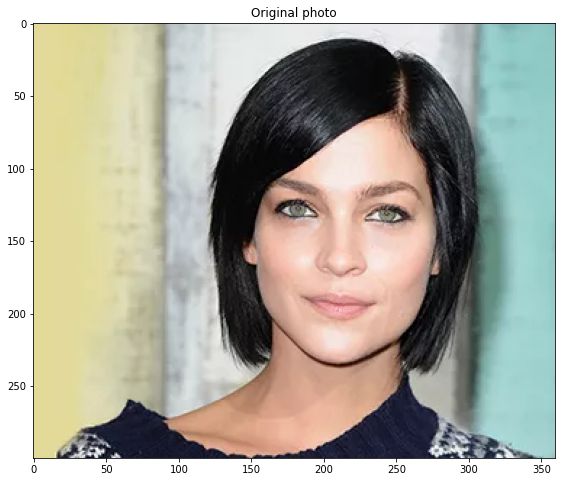

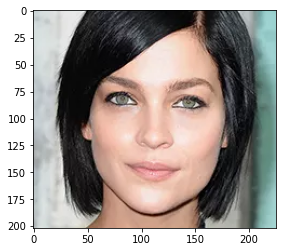

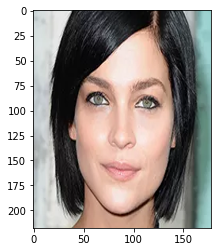

125 162
face extracted
[array([[40.505554]], dtype=float32), array([[0.36150795, 0.569676  , 0.04997598, 0.0151066 , 0.00373354]],
      dtype=float32), array([[0.02318905, 0.9942443 ]], dtype=float32), array([[0.68915546, 0.2271815 , 0.00558521, 0.07807776]], dtype=float32)]


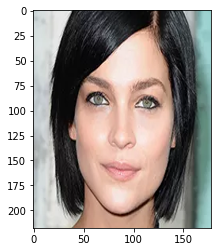

In [ ]:
# (width x height)
# 178×218
# 218 282
plt.figure(figsize=(10, 8))
img = image.load_img('/content/black.jpg')
plt.title("Original photo")
plt.imshow(img)
plt.show()

face_image = extract_face('/content/black.jpg', (WIDTH,HEIGHT))
print("face extracted")
plt.imshow(face_image)

x = image.img_to_array(face_image)
x = np.expand_dims(x, axis=0)

images = np.vstack([x])
prediction = model.predict(images)
print(prediction)

In [ ]:
labels = list(sorted(dataset_dict['hair_id'].values()))
predicted_label = sorted(labels)[prediction[3].argmax()]
predicted_label

'Black_Hair'

In [ ]:
labels = list(sorted(dataset_dict['expression_id'].values()))
predicted_label = sorted(labels)[prediction[1].argmax()]
predicted_label

'fear_surprise'

# Convert to tensorflow js

In [ ]:
!pip install tensorflowjs

     |████████████████████████████████| 77 kB 6.0 MB/s 
     |████████████████████████████████| 462 kB 8.6 MB/s 


In [ ]:
# bash
!tensorflowjs_converter --input_format keras /content/drive/MyDrive/TFG/face_descriptor_model_corrected_data_15_05_2022_width_height_correct.h5 /content/drive/MyDrive/TFG/tensorflowjs_models/try1

In [ ]:
import tensorflowjs as tfjs
tfjs.converters.save_keras_model(model, '/content/drive/MyDrive/TFG/try2/')